In [1]:
library(tidyverse)
library(Seurat)
library(Signac)
library(ggpubr)
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cit

In [2]:
charm=readRDS("../1_createobj_embedding/charm.rds")

In [3]:
'%!in%' <- function(x,y)!('%in%'(x,y))
charm_subset = subset(charm, subset = celltype %!in% c("Ex_Unknown1","Ex_Unknown2","Inh_Unknown1","Inh_Unknown2"))
Idents(charm_subset) = "celltype"

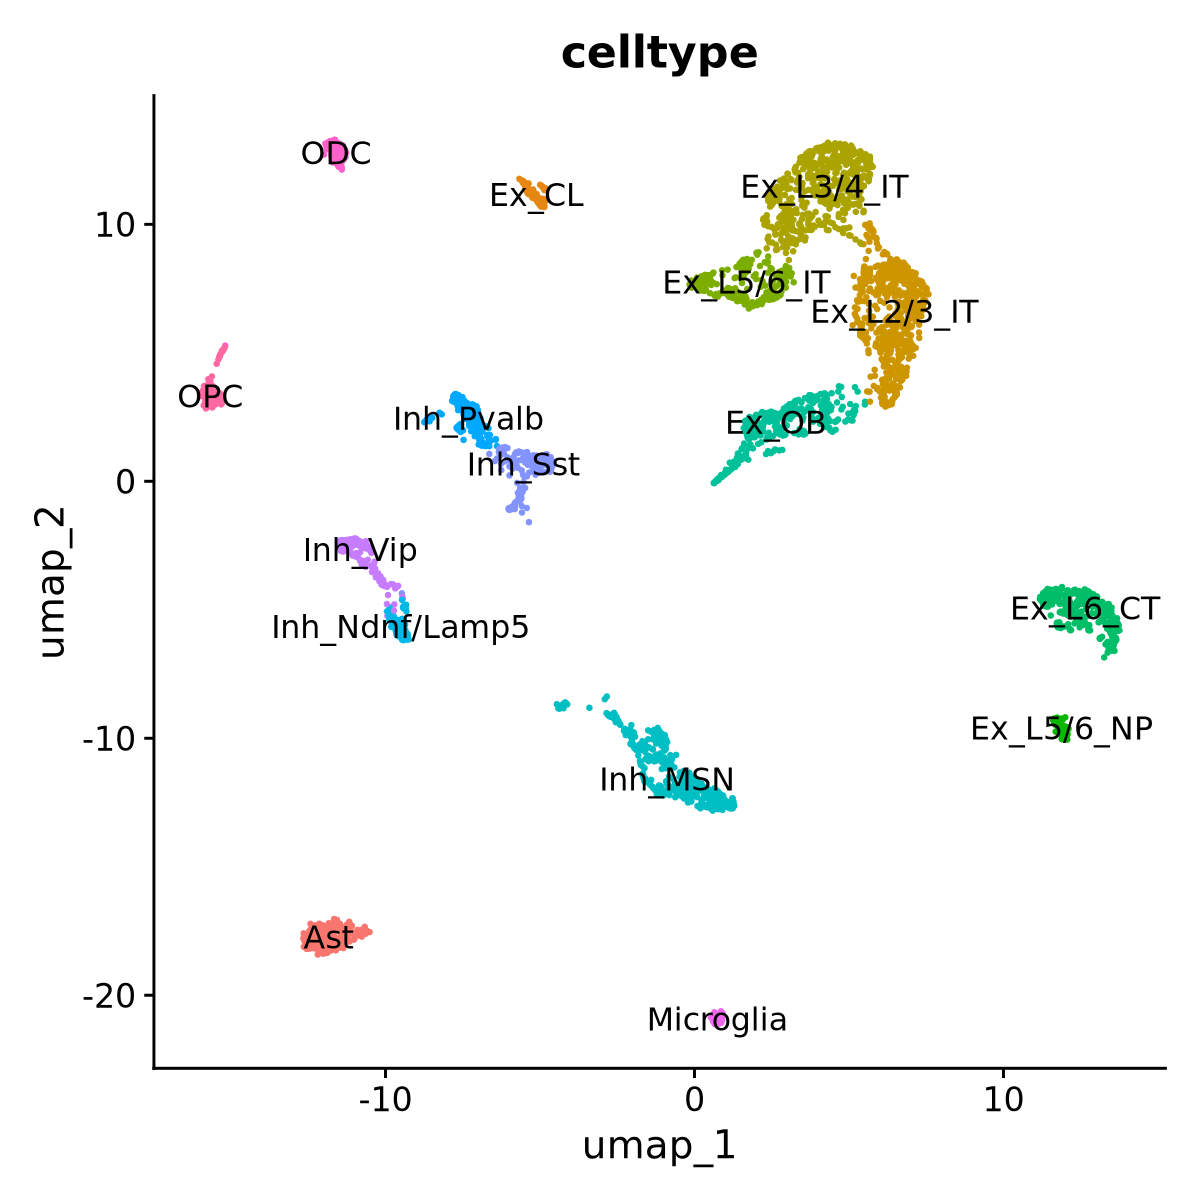

In [4]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=200)
DimPlot(charm_subset,group.by = "celltype",label=T)+NoLegend()

In [5]:
charm_subset[[]] %>% select(cellname,celltype) %>% write_tsv("cell_cluster.tsv")

In [6]:
# 2. get housekeeping genes and celltype specific genes
Idents(charm_subset) = "celltype"
allmarkers = FindAllMarkers(charm_subset, only.pos = TRUE)

Calculating cluster Inh_Sst



Calculating cluster Ex_L3/4_IT

Calculating cluster Ex_L6_CT

Calculating cluster Inh_MSN

Calculating cluster Ex_OB

Calculating cluster Microglia

Calculating cluster Ex_L5/6_IT

Calculating cluster Ex_L5/6_NP

Calculating cluster Ex_L2/3_IT

Calculating cluster Ast

Calculating cluster Ex_CL

Calculating cluster Inh_Ndnf/Lamp5

Calculating cluster Inh_Pvalb

Calculating cluster ODC

Calculating cluster Inh_Vip

Calculating cluster OPC



In [7]:
tss_df = read_tsv("./tss.bed",col_names = FALSE)
names(tss_df) <- c("chrom","start","end","gene","strand")

Rows: 21251 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): X1, X4, X5
dbl (2): X2, X3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
celltype_specific = allmarkers %>% filter(p_val_adj < 0.01,pct.1 - pct.2 > 0.1,avg_log2FC > 1) %>% group_by(cluster) %>% slice(1:200) %>% select(gene)
celltype_specific %>% left_join(tss_df) %>% select(3:5,2,1) -> celltype_specific
names(celltype_specific) = c("chrom", "start", "end", "gene","type")
celltype_specific %>% write_tsv("celltype_specific_genes.txt", col_names=FALSE)

Adding missing grouping variables: `cluster`
Joining with `by = join_by(gene)`


In [9]:
# 提取原始表达矩阵
expr_matrix <- GetAssayData(charm_subset, slot = "counts")
detection_rate <- rowSums(expr_matrix > 0) / ncol(expr_matrix)
mean_expression <- rowMeans(expr_matrix)
gini = function(x) {
  n = length(x)
  mean_x = mean(x)
  sum_x = sum(x)
  sum((rank(x) - 0.5) * x) / sum_x / n - mean_x / n
}
gini_index = apply(expr_matrix, 1, gini)
gene_stats <- data.frame(
  gene = rownames(expr_matrix),
  detection_rate = detection_rate,
  mean_expression = mean_expression,
  gini_index = gini_index
)


Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
i Please use the `layer` argument instead."


Warning message:
"Using `bins = 30` by default. Pick better value with the argument `bins`."
Warning message:
"Removed 8794 rows containing non-finite outside the scale range (`stat_bin()`)."


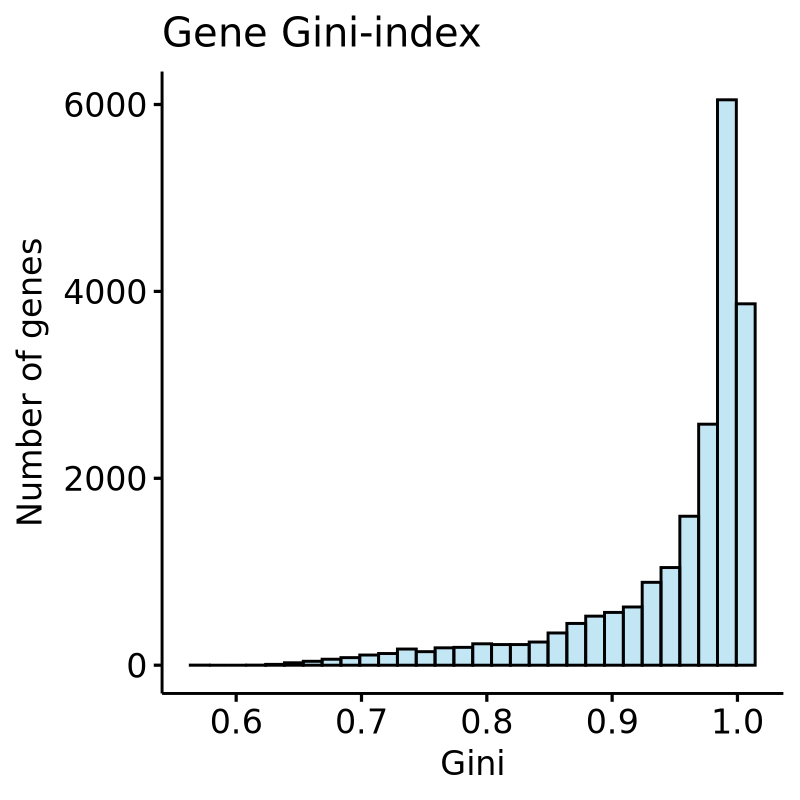

In [10]:
# histogram of detection rate
options(repr.plot.width=4, repr.plot.height=4,repr.plot.res=200)
gene_stats %>% gghistogram(x="gini_index", fill="skyblue", color="black")  + labs(title="Gene Gini-index", x="Gini", y="Number of genes") #+ scale_y_log10()

In [11]:
house_keeping_genes = gene_stats %>% dplyr::filter(!gene %in% (allmarkers %>% filter(p_val_adj < 0.01) %>% pull(gene))) %>%
     arrange(gini_index) %>% head(200)  %>% select(gene) %>%
      left_join(tss_df) %>% select(chrom,start,end,gene) %>% mutate(type = "house_keeping") 
house_keeping_genes %>% write_tsv("housekeeping_genes.txt", col_names=FALSE)

Joining with `by = join_by(gene)`


In [12]:
genes = rbind(house_keeping_genes,celltype_specific)  

In [13]:
genes %>% head()

,chrom,start,end,gene,type
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,chr6,38551465,38551466,Luc7l2,house_keeping
2,chr17,63500016,63500017,Fbxl17,house_keeping
3,chr2,48949523,48949524,Mbd5,house_keeping
4,chr15,35371160,35371161,Vps13b,house_keeping
5,chr4,44756568,44756569,Zcchc7,house_keeping
6,chr6,38440533,38440534,Ubn2,house_keeping


In [14]:
get_optimized_colors <- function(palette, n) {
  colorRampPalette(brewer.pal(9, palette))(max(n, 9))[seq_len(n)] # 确保最小取色数
}
excitatory_colors <- get_optimized_colors("Reds", 12)[3:12]  
inhibitory_colors <- get_optimized_colors("Blues", 11)[3:12] 
glia_colors <- get_optimized_colors("Greens", 7)[3:6]     


celltype_colors <- c(
  "Ex_OB" = excitatory_colors[3],
  "Ex_L2/3_IT" = excitatory_colors[4],
  "Ex_L3/4_IT" = excitatory_colors[5],
  "Ex_L5/6_IT" = excitatory_colors[6],
  "Ex_L5/6_NP" = excitatory_colors[7],
  "Ex_L6_CT" = excitatory_colors[8],   
  "Ex_CL" = excitatory_colors[9],
  
  # 抑制性神经元（7类）
  "Inh_Pvalb" = inhibitory_colors[3],
  "Inh_Sst" = inhibitory_colors[4],  
  "Inh_MSN" = inhibitory_colors[5], 
  "Inh_Vip" = inhibitory_colors[6],
  "Inh_Ndnf/Lamp5" = inhibitory_colors[7],
  
  # 胶质细胞（4类）
  "Ast" = glia_colors[1],
  "OPC" = glia_colors[2],
  "ODC" = glia_colors[3],
  "Microglia" = glia_colors[4],

  "house_keeping" = "grey"
)

In [15]:
rna_expression_matrix = charm_subset[["SCT"]]@data %>% as.matrix()
#rna_expression_matrix %>% t() %>% scale() %>% t() -> rna_expression_matrix
cell_metadata = charm_subset[[]] %>% select(cellname,celltype)

In [16]:
genes_filtered <- genes[genes$gene %in% rownames(rna_expression_matrix), ]
rna_expression_matrix_ordered <- rna_expression_matrix[genes_filtered$gene, ]
cell_metadata <- cell_metadata[order(cell_metadata$cellname), ]
rna_expression_matrix_ordered <- rna_expression_matrix_ordered[, cell_metadata$cellname]

gene_type_annotation <- genes_filtered$type
names(gene_type_annotation) <- genes_filtered$gene

row_ha <- rowAnnotation(
  gene_type = gene_type_annotation,
  col = list(cell_type = celltype_colors),
  annotation_name_side = "top"
)

cell_type_annotation <- cell_metadata$celltype
names(cell_type_annotation) <- cell_metadata$cellname

col_ha <- HeatmapAnnotation(
  cell_type = cell_type_annotation,
  col = list(cell_type = celltype_colors), 
  annotation_name_side = "left"
)


In [17]:
# --- 3. Generate the ComplexHeatmap ---
ht_colors = colorRamp2(c(0,0.5,1), rev(c("#00FF00", "#c091a3","#e952f8")))

ht <- Heatmap(
  rna_expression_matrix_ordered,
  name = "Expression", 
  col = ht_colors,

  # Row annotation
  left_annotation = row_ha,
  row_split = gene_type_annotation, 
  row_title_rot = 0, 

  # Column annotation
  top_annotation = col_ha,
  column_split = cell_type_annotation, 
  column_title_rot = 45, 
  cluster_rows = FALSE,
  cluster_columns = FALSE,
  show_row_names = FALSE, 
  show_column_names = FALSE, 
  heatmap_legend_param = list(title = "Expression Value")
)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



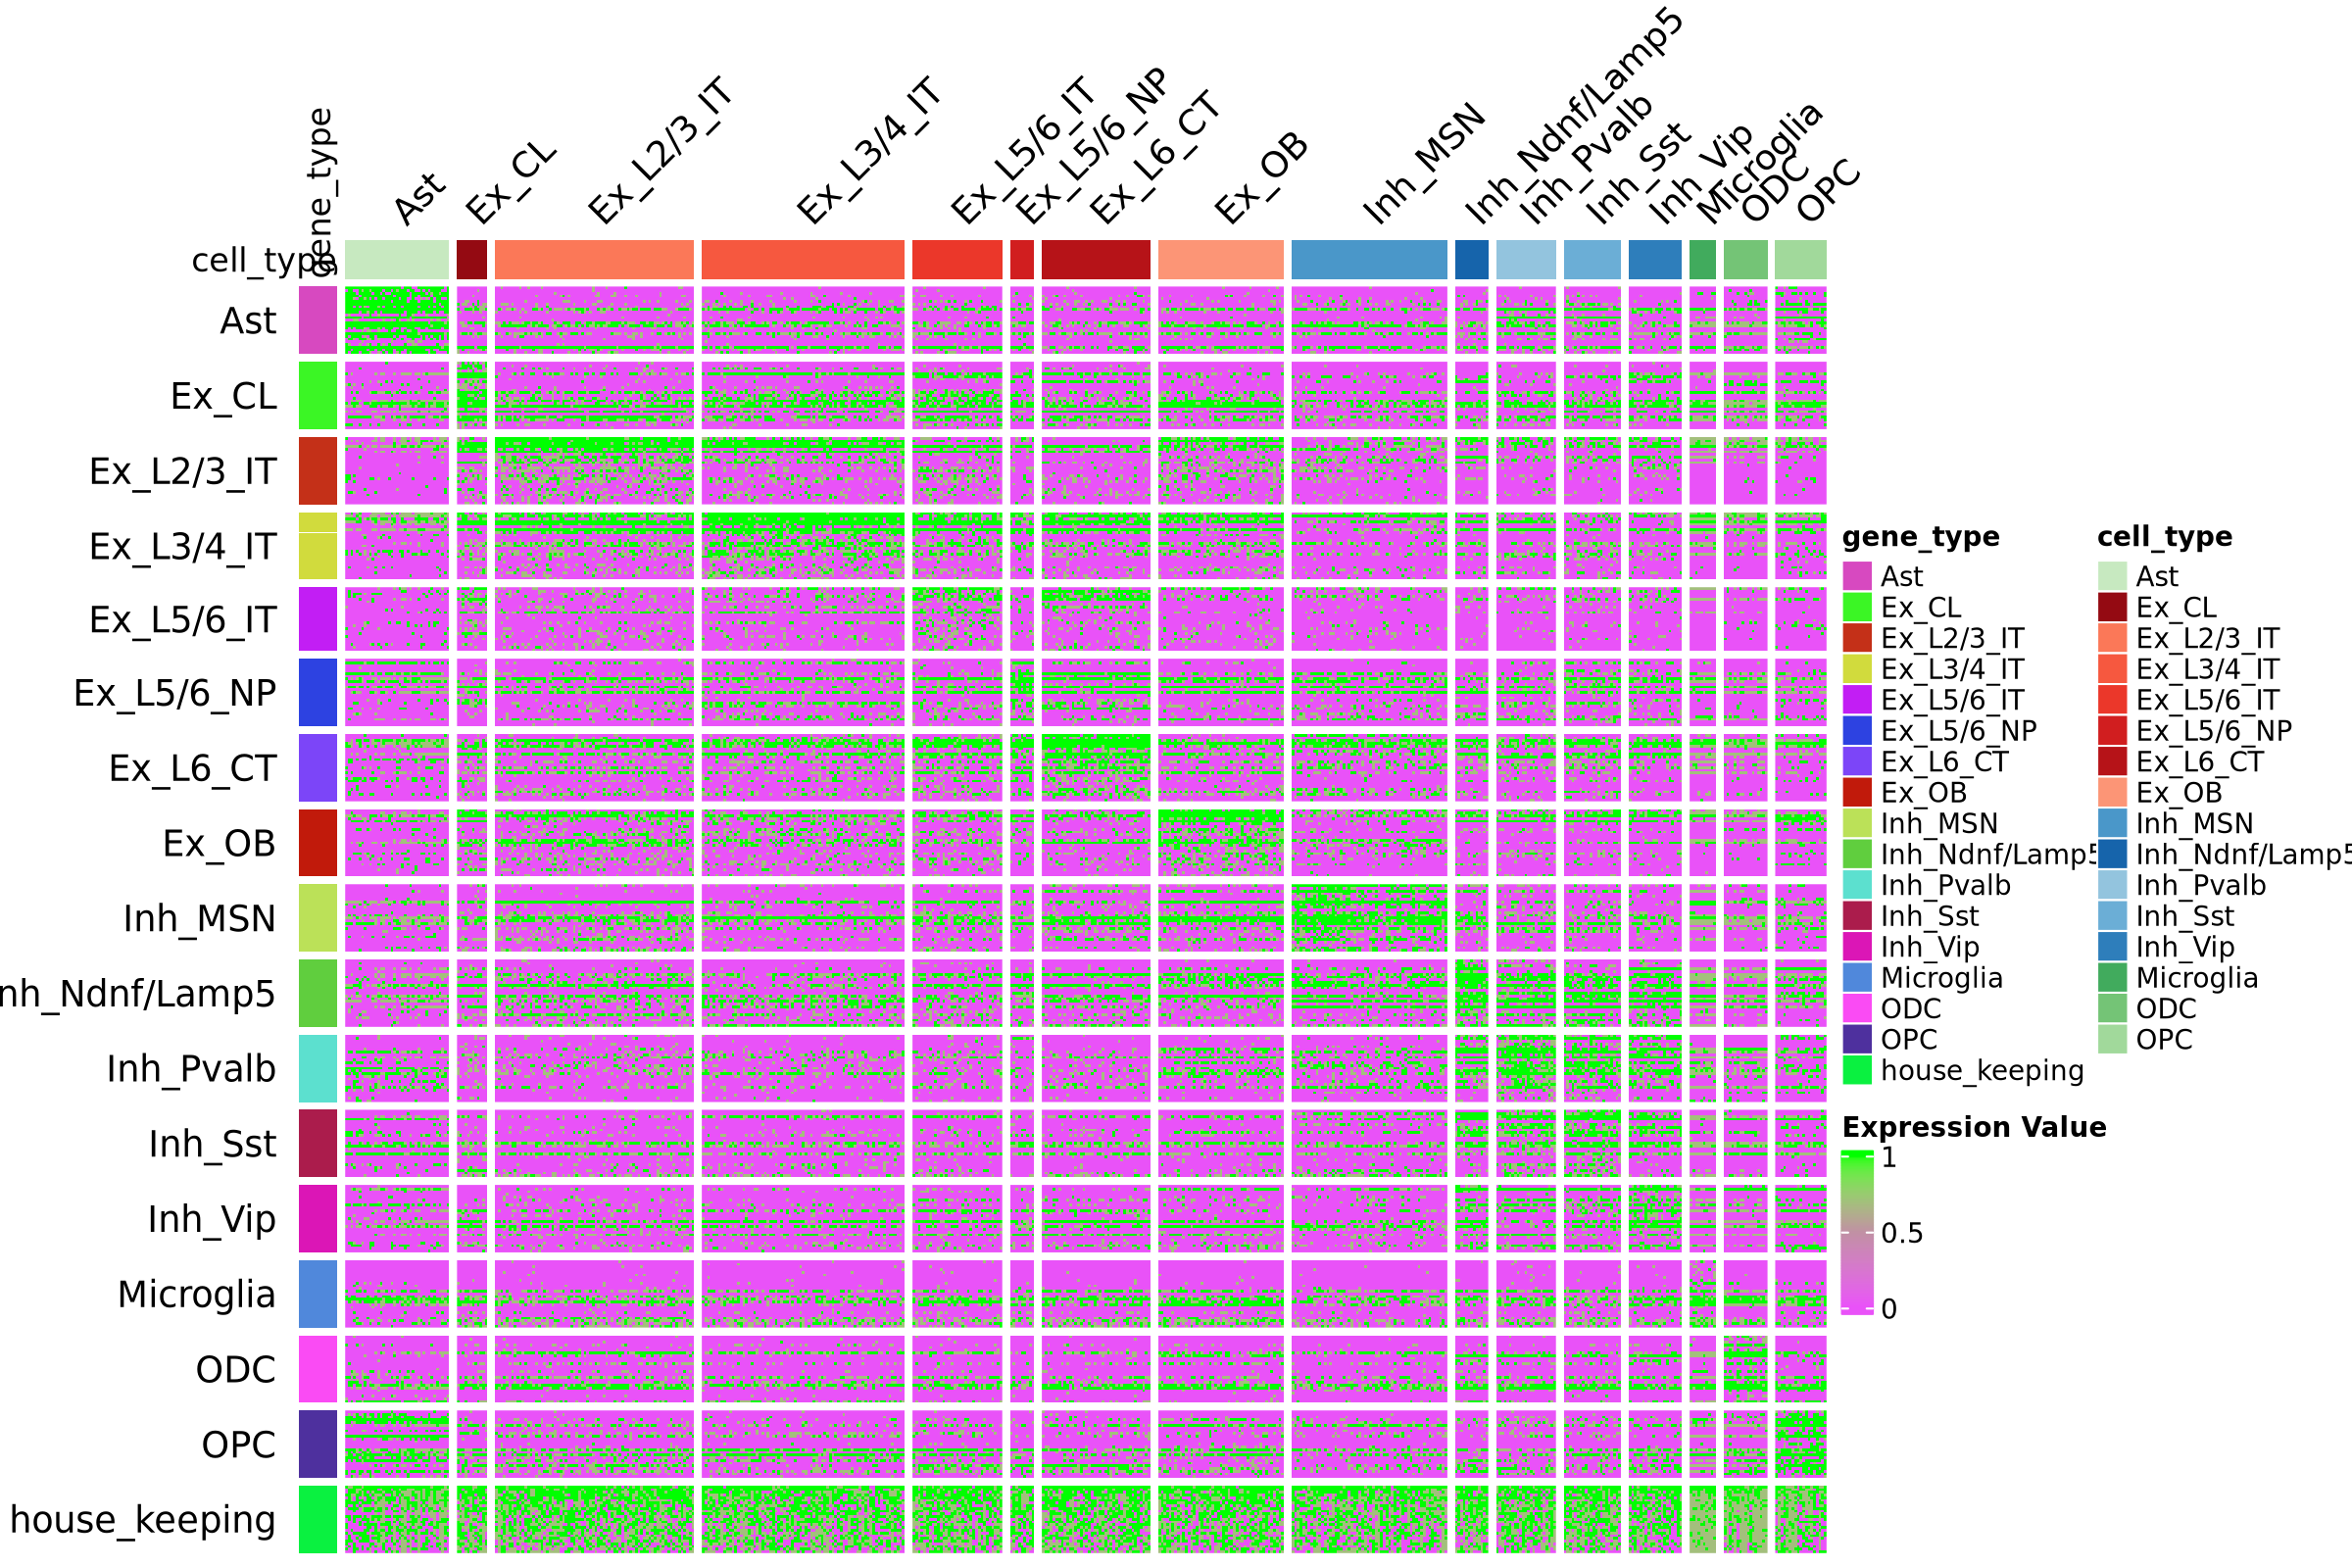

In [18]:
options(repr.plot.width=12, repr.plot.height=8,repr.plot.res=200)
draw(ht,heatmap_legend_side = "right",annotation_legend_side = "right")

In [19]:
rna_expression_matrix %>% as.data.frame() %>% rownames_to_column("gene") %>% inner_join(genes %>% select(gene,type)) %>% 
    select(-gene) %>% group_by(type) %>% summarise_all(mean) %>% column_to_rownames("type") -> groupbygenetype_expmat

Joining with `by = join_by(gene)`


In [20]:
mat = Heatmap(
    groupbygenetype_expmat,
    name = "Expression", 
    col = ht_colors,
    top_annotation = col_ha,
    column_split = cell_type_annotation,
    cluster_rows = FALSE,
    cluster_columns = FALSE,
    show_row_names = TRUE, 
    show_column_names = FALSE, 
    heatmap_legend_param = list(title = "Mean expression"),
    column_title_rot = 45
)

Warning message:
"The input is a data frame-like object, convert it to a matrix."
`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

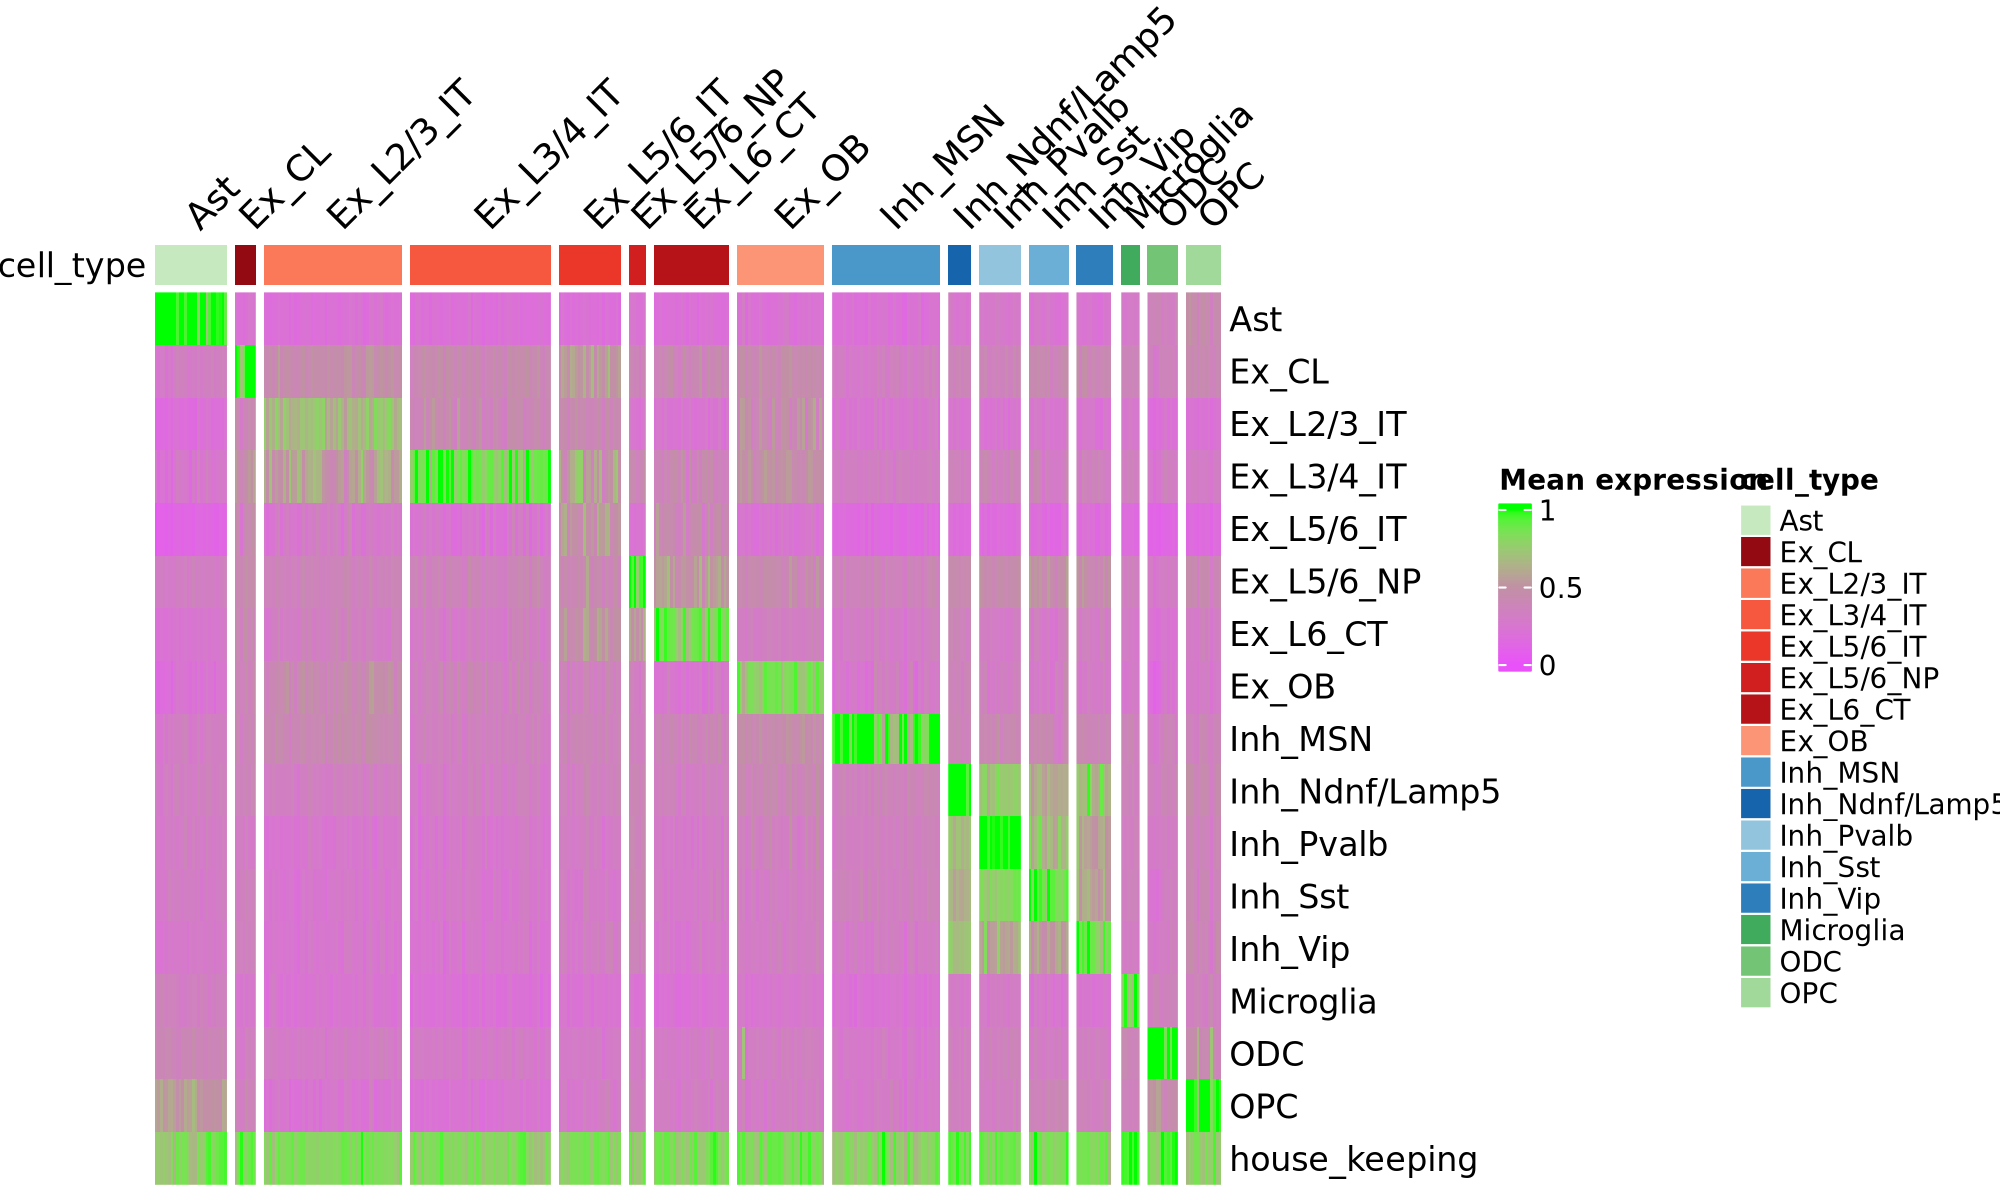

In [24]:
options(repr.plot.width=10, repr.plot.height=6,repr.plot.res=200)
draw(mat, heatmap_legend_side = "right", annotation_legend_side = "right")

# save to pdf 
pdf("figures/celltype_specific_genes_heatmap.pdf", width = 10, height = 6)
draw(mat, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()